# Segmentez les clients d'un site e-commerce - Part 2 : Clustering

This notebook aims at performing a customer segmentation using clustering techniques. We use Olist database available freely on Kaggle at this link: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce 

Please note that this is the second notebook of series of three: 1-EDA, 2-Clustering, 3-Update schemes

In [2]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, cluster, metrics # from metrics, we mainly want silhouette_score and adjusted_rand_score

In [3]:
# Style
font_perso = {'family': 'serif',
              'color':  'k',
              'size': 18,
             }

sns.set_style("darkgrid")

pd.options.display.float_format = '{:,.2f}'.format

In [4]:
# Full database and rfm data loading
db_full = pd.read_csv(r'./Data/olist_db_full.csv', sep = ',', low_memory=False)
rfm_db = pd.read_csv(r'./Data/olist_rfm_db.csv', sep = ',', low_memory=False)

In [5]:
# Merging with RFM db
db_full = pd.merge(db_full, rfm_db, on ='customer_unique_id', how='left')

In [6]:
db_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109638 entries, 0 to 109637
Data columns (total 50 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    109638 non-null  object 
 1   customer_unique_id             109638 non-null  object 
 2   customer_zip_code_prefix       109638 non-null  int64  
 3   customer_city                  109638 non-null  object 
 4   customer_state                 109638 non-null  object 
 5   order_id                       109638 non-null  object 
 6   order_status                   109638 non-null  object 
 7   order_purchase_timestamp       109638 non-null  object 
 8   order_approved_at              109624 non-null  object 
 9   order_delivered_carrier_date   108563 non-null  object 
 10  order_delivered_customer_date  107458 non-null  object 
 11  order_estimated_delivery_date  109638 non-null  object 
 12  payment_sequential            

### Feature engineering

Before we do the segmentation, we're gonna create some other synthetic metrics like the average number of payments for a client

In [7]:
# Average number of payments per order
avg_nb_payments = db_full.groupby('customer_unique_id')['payment_sequential'].mean()
db_full = pd.merge(db_full, avg_nb_payments, on ='customer_unique_id')

In [8]:
# Usual type of payment
usual_payment_type = db_full.groupby('customer_unique_id')['payment_type'].agg(pd.Series.mode)
db_full = pd.merge(db_full, usual_payment_type, on ='customer_unique_id')

In [9]:
# Average review given
avg_review_score = db_full.groupby('customer_unique_id')['review_score'].mean()
db_full = pd.merge(db_full, avg_review_score, on ='customer_unique_id')

In [10]:
# Average number of products par order
avg_nb_products = db_full.groupby('customer_unique_id')['order_item_id'].mean()
db_full = pd.merge(db_full, avg_nb_products, on ='customer_unique_id')

In [11]:
# Average price of shipping
avg_shipping_price = db_full.groupby('customer_unique_id')['freight_value'].mean()
db_full = pd.merge(db_full, avg_shipping_price, on ='customer_unique_id')

In [12]:
# How frequently the order arrives late?
often_late = db_full.groupby('customer_unique_id')['Late?'].sum()
db_full = pd.merge(db_full, often_late, on ='customer_unique_id')

In [13]:
# What is the usual type of product each customer buy?
product_type = db_full.groupby('customer_unique_id')['product_category_name_english'].agg(pd.Series.mode)
db_full = pd.merge(db_full, product_type, on ='customer_unique_id')

In [14]:
db_full.rename(columns = {'payment_sequential_y':'avg_nb_payments', 
                          'review_score_y':'avg_review_score',
                          'payment_type_y':'usual_payment_type',
                          'order_item_id_y' : 'avg_nb_products',
                          'freight_value_y' : 'avg_shipping_price',
                          'Late?_y' : 'often_late?',
                          'product_category_name_english_y':'product_type'
                         }, inplace = True)

### Data preparation

As we can not do clustering on categorical variables, we are going to encode them using a Onehotencoding. Regarding numerical features, we are also going to rescale them using RobustScaler wich is less sensitive to outliers.

In [15]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

In [16]:
## To drop: 
Columns_to_drop = ['customer_id','order_id','price','freight_value_x','order_status','order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'order_item_id_x','payment_sequential_x','payment_type_x','payment_installments', 'payment_value', 'review_id', 'review_score_x','review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp', 'seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state','product_id','shipping_limit_date','product_category_name','product_category_name_english_x','product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm','customer_city','customer_state','Late?_x','R_rank_norm','F_rank_norm','M_rank_norm','RFM_score','Customer_segment','How_late?']

In [17]:
cls_df = db_full.drop(Columns_to_drop, axis=1)

In [18]:
cls_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109638 entries, 0 to 109637
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   customer_unique_id        109638 non-null  object 
 1   customer_zip_code_prefix  109638 non-null  int64  
 2   Recency                   109638 non-null  int64  
 3   Frequency                 109638 non-null  int64  
 4   Monetary                  109638 non-null  float64
 5   avg_nb_payments           109638 non-null  float64
 6   usual_payment_type        109638 non-null  object 
 7   avg_review_score          109638 non-null  float64
 8   avg_nb_products           109638 non-null  float64
 9   avg_shipping_price        109638 non-null  float64
 10  often_late?               109638 non-null  int64  
 11  product_type              109638 non-null  object 
dtypes: float64(5), int64(4), object(3)
memory usage: 10.9+ MB


In [19]:
# We want to treat zip_code as a categorical variable
cls_df['customer_zip_code_prefix'] = cls_df['customer_zip_code_prefix'].astype(str) # it's gonna be complicated so we drop it
cls_df

,customer_unique_id,customer_zip_code_prefix,Recency,Frequency,Monetary,avg_nb_payments,usual_payment_type,avg_review_score,avg_nb_products,avg_shipping_price,often_late?,product_type
0,861eff4711a542e4b93843c6dd7febb0,14409,474,1,124.99,1.00,credit_card,4.00,1.00,21.88,0,office_furniture
1,290c77bc529b7ac935b93aa66c333dc3,9790,233,1,289.00,1.00,credit_card,5.00,1.00,46.48,0,housewares
2,060e732b5b29e8181a18229c7b0b2b5e,1151,106,1,139.94,1.00,credit_card,5.00,1.00,17.79,1,office_furniture
3,259dac757896d24d7702b9acbbff3f3c,8775,173,1,149.94,1.00,credit_card,5.00,1.00,23.36,0,office_furniture
4,345ecd01c38d18a9036ed96c73b8d066,13056,35,1,230.00,1.00,credit_card,5.00,1.00,22.25,0,home_confort
...,...,...,...,...,...,...,...,...,...,...,...,...
109633,4b5820135d360a45552b5163835b1d89,35500,259,1,55.00,1.00,credit_card,1.00,1.00,20.88,0,housewares
109634,1a29b476fee25c95fbafc67c5ac95cf8,3937,148,1,74.90,1.00,credit_card,4.00,1.00,13.88,0,books_general_interest
109635,d52a67c98be1cf6a5c84435bd38d095d,6764,152,1,114.90,1.00,credit_card,5.00,1.00,14.16,0,sports_leisure
109636,e9f50caf99f032f0bf3c55141f019d99,60115,147,1,37.00,1.00,credit_card,1.00,1.00,19.04,1,health_beauty


In [20]:
# Set customers as new index
cls_df = cls_df.set_index('customer_unique_id')
cls_df

,customer_zip_code_prefix,Recency,Frequency,Monetary,avg_nb_payments,usual_payment_type,avg_review_score,avg_nb_products,avg_shipping_price,often_late?,product_type
customer_unique_id,,,,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,14409,474,1,124.99,1.00,credit_card,4.00,1.00,21.88,0,office_furniture
290c77bc529b7ac935b93aa66c333dc3,9790,233,1,289.00,1.00,credit_card,5.00,1.00,46.48,0,housewares
060e732b5b29e8181a18229c7b0b2b5e,1151,106,1,139.94,1.00,credit_card,5.00,1.00,17.79,1,office_furniture
259dac757896d24d7702b9acbbff3f3c,8775,173,1,149.94,1.00,credit_card,5.00,1.00,23.36,0,office_furniture
345ecd01c38d18a9036ed96c73b8d066,13056,35,1,230.00,1.00,credit_card,5.00,1.00,22.25,0,home_confort
...,...,...,...,...,...,...,...,...,...,...,...
4b5820135d360a45552b5163835b1d89,35500,259,1,55.00,1.00,credit_card,1.00,1.00,20.88,0,housewares
1a29b476fee25c95fbafc67c5ac95cf8,3937,148,1,74.90,1.00,credit_card,4.00,1.00,13.88,0,books_general_interest
d52a67c98be1cf6a5c84435bd38d095d,6764,152,1,114.90,1.00,credit_card,5.00,1.00,14.16,0,sports_leisure


In [21]:
cls_df.dtypes

customer_zip_code_prefix     object
Recency                       int64
Frequency                     int64
Monetary                    float64
avg_nb_payments             float64
usual_payment_type           object
avg_review_score            float64
avg_nb_products             float64
avg_shipping_price          float64
often_late?                   int64
product_type                 object
dtype: object

As we have some problems with mixed-type columns, we are going to force-type each of them in se desired format

In [22]:
cls_df[['Recency', 'Frequency', 'Monetary', 'avg_nb_payments', 'avg_review_score', 'avg_nb_products', 'avg_shipping_price', 'often_late?']] = cls_df[['Recency', 'Frequency', 'Monetary', 'avg_nb_payments', 'avg_review_score', 'avg_nb_products', 'avg_shipping_price', 'often_late?']].astype('float64')
cls_df[['product_type', 'usual_payment_type']] = cls_df[['product_type', 'usual_payment_type']].astype('str')
cls_df.dtypes

customer_zip_code_prefix     object
Recency                     float64
Frequency                   float64
Monetary                    float64
avg_nb_payments             float64
usual_payment_type           object
avg_review_score            float64
avg_nb_products             float64
avg_shipping_price          float64
often_late?                 float64
product_type                 object
dtype: object

Now that all our variables are customer-wise, we can delete duplicated rows

In [23]:
# Delete potential duplicated rows
cls_df.drop_duplicates(inplace = True)
cls_df

,customer_zip_code_prefix,Recency,Frequency,Monetary,avg_nb_payments,usual_payment_type,avg_review_score,avg_nb_products,avg_shipping_price,often_late?,product_type
customer_unique_id,,,,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,14409,474.00,1.00,124.99,1.00,credit_card,4.00,1.00,21.88,0.00,office_furniture
290c77bc529b7ac935b93aa66c333dc3,9790,233.00,1.00,289.00,1.00,credit_card,5.00,1.00,46.48,0.00,housewares
060e732b5b29e8181a18229c7b0b2b5e,1151,106.00,1.00,139.94,1.00,credit_card,5.00,1.00,17.79,1.00,office_furniture
259dac757896d24d7702b9acbbff3f3c,8775,173.00,1.00,149.94,1.00,credit_card,5.00,1.00,23.36,0.00,office_furniture
345ecd01c38d18a9036ed96c73b8d066,13056,35.00,1.00,230.00,1.00,credit_card,5.00,1.00,22.25,0.00,home_confort
...,...,...,...,...,...,...,...,...,...,...,...
4b5820135d360a45552b5163835b1d89,35500,259.00,1.00,55.00,1.00,credit_card,1.00,1.00,20.88,0.00,housewares
1a29b476fee25c95fbafc67c5ac95cf8,3937,148.00,1.00,74.90,1.00,credit_card,4.00,1.00,13.88,0.00,books_general_interest
d52a67c98be1cf6a5c84435bd38d095d,6764,152.00,1.00,114.90,1.00,credit_card,5.00,1.00,14.16,0.00,sports_leisure


### Clustering preparation's steps

In [24]:
# Categorical and numerical features recoding
categorical_features = ['product_type', 'usual_payment_type']
numerical_features = ['Recency', 'Frequency', 'Monetary', 'avg_nb_payments',
                       'avg_review_score', 'avg_nb_products', 'avg_shipping_price', 'often_late?']


## Other (and more elegant) way to do it
#categorical_features = list(cls_df.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns)
#numerical_features = list(cls_df.select_dtypes(include=['int64','float64', 'uint8']).columns)

In [25]:
# Robust Scaling
robust_scaler = preprocessing.RobustScaler()

robust_data = robust_scaler.fit_transform(cls_df[numerical_features])
cls_robust = pd.DataFrame(robust_data, index=cls_df.index, columns = cls_df[numerical_features].columns)

In [26]:
# One Hot Encoding
one_hot_encoder = preprocessing.OneHotEncoder(sparse=False, categories='auto')
onehot_data = one_hot_encoder.fit_transform(cls_df[categorical_features])
cat_names = one_hot_encoder.get_feature_names_out()

one_hot_encoded_data = pd.DataFrame(onehot_data, index=cls_df.index)
one_hot_encoded_data.columns = cat_names

cls_recoded = pd.concat([cls_robust, one_hot_encoded_data], axis=1)

### K-means ++

First, we are going to check the optimal number of clusters according to the Elbow method.

Training time : 94 seconds


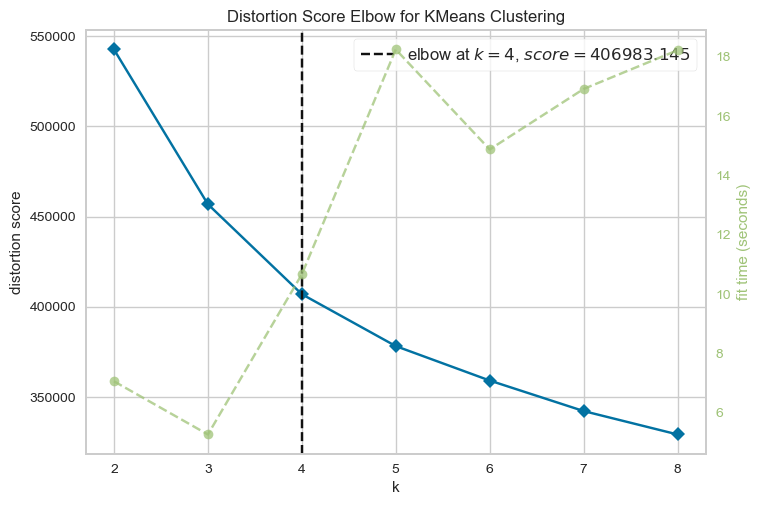

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
# Elbow research
%matplotlib inline
import time
import yellowbrick

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

start = time.time()

visualizer = KElbowVisualizer(KMeans(), k=(2,9))
visualizer.fit(cls_recoded)

stop = time.time()
training_time = stop-start   

print('Training time :', round(training_time), 'seconds')
visualizer.show()

According to this first method, our customers can be represented by four groups. Let analyse the density and separation of each group.

Training time : 329 seconds


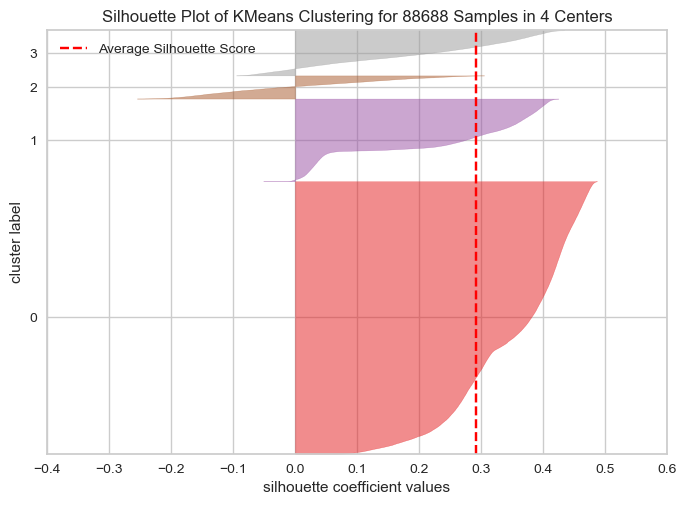

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 88688 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [28]:
# Silouhette visualization
from yellowbrick.cluster import SilhouetteVisualizer
start = time.time()

optimal_K = visualizer.elbow_value_

silhouette_visualizer = SilhouetteVisualizer(KMeans(optimal_K))
silhouette_visualizer.fit(cls_recoded)

stop = time.time()
training_time = stop-start   

print('Training time :', round(training_time), 'seconds')
silhouette_visualizer.show()

What stands out of this visualization is that on the four groups, 1 is very small and not that much dense, while two groups seem well balanced, and a last one very large. Let confirm this result with a last visualization.

Training time : 8 seconds


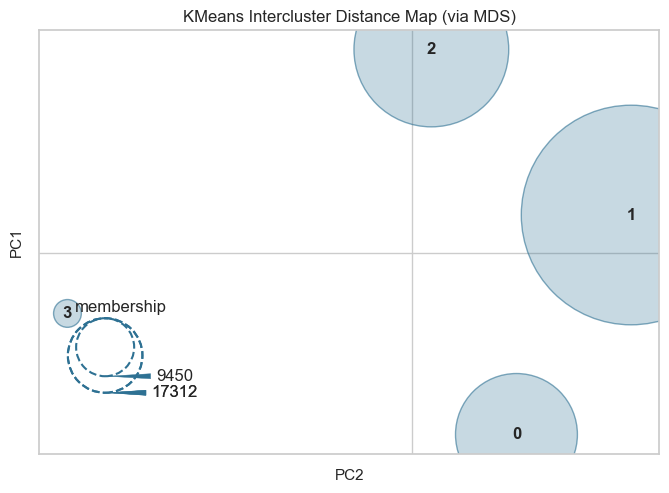

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [29]:
# Intercluster distance
from yellowbrick.cluster import InterclusterDistance

start = time.time()

intercluster_visualizer = InterclusterDistance(KMeans(optimal_K))
intercluster_visualizer.fit(cls_recoded)

stop = time.time()
training_time = stop-start   

print('Training time :', round(training_time), 'seconds')
intercluster_visualizer.show()

The distance between our 4 groups with regards the two principal components is quite large, meaning that our groups are indeed well defined and separated. Although one of the four groups is really small, it is the farest from the other, underlining the singularity of this group of customers.

To give our client actionnable insights, we now have to find what are the main characteristics of those groups and what distinguish each of them from the other ones. 

In [30]:
# Training of the KMeans+ model with optimal params
start = time.time()

KMeans_final = KMeans(init='k-means++',
                      n_clusters=4,
                      algorithm='lloyd').fit(cls_recoded)

# Silhouette score
print("Silhouette Score: %0.3f"
      % metrics.silhouette_score(cls_recoded, KMeans_final.labels_))

stop = time.time()
training_time = stop-start

print('Training time :', round(training_time), 'seconds')

Silhouette Score: 0.291
Training time : 163 seconds


In [31]:
# Assign labels
cls_df['KMeans_label'] = KMeans_final.labels_
cls_df.head(10)

,customer_zip_code_prefix,Recency,Frequency,Monetary,avg_nb_payments,usual_payment_type,avg_review_score,avg_nb_products,avg_shipping_price,often_late?,product_type,KMeans_label
customer_unique_id,,,,,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,14409,474.00,1.00,124.99,1.00,credit_card,4.00,1.00,21.88,0.00,office_furniture,3
290c77bc529b7ac935b93aa66c333dc3,9790,233.00,1.00,289.00,1.00,credit_card,5.00,1.00,46.48,0.00,housewares,0
060e732b5b29e8181a18229c7b0b2b5e,1151,106.00,1.00,139.94,1.00,credit_card,5.00,1.00,17.79,1.00,office_furniture,3
259dac757896d24d7702b9acbbff3f3c,8775,173.00,1.00,149.94,1.00,credit_card,5.00,1.00,23.36,0.00,office_furniture,3
345ecd01c38d18a9036ed96c73b8d066,13056,35.00,1.00,230.00,1.00,credit_card,5.00,1.00,22.25,0.00,home_confort,3
4c93744516667ad3b8f1fb645a3116a4,89254,322.00,2.00,506.52,1.00,['credit_card' 'debit_card'],5.00,1.00,29.68,0.00,['sports_leisure' 'telephony'],1
4c93744516667ad3b8f1fb645a3116a4,89253,322.00,2.00,506.52,1.00,['credit_card' 'debit_card'],5.00,1.00,29.68,0.00,['sports_leisure' 'telephony'],1
addec96d2e059c80c30fe6871d30d177,4534,195.00,1.00,14.99,1.00,credit_card,5.00,1.00,7.78,0.00,computers_accessories,3
1175e95fb47ddff9de6b2b06188f7e0d,81560,227.00,3.00,84.98,1.00,debit_card,5.00,1.00,14.10,0.00,furniture_decor,3


Now that our customers do have a label corresponding to the group found by the KMeans algorithm, we are going to visualize the specificity of those four groups.

In [32]:
# Creating the groups
cls_grouped = cls_df.groupby('KMeans_label').mean()
groups_size = cls_df.groupby('KMeans_label').size()
cls_grouped.head(10)

,Recency,Frequency,Monetary,avg_nb_payments,avg_review_score,avg_nb_products,avg_shipping_price,often_late?
KMeans_label,,,,,,,,
0,230.20,1.10,160.61,1.01,4.33,1.03,35.62,0.07
1,246.89,2.72,463.58,1.19,4.16,1.41,19.60,0.15
2,249.48,1.26,100.80,1.01,1.86,1.10,16.46,0.27
3,242.30,1.14,87.81,1.01,4.75,1.04,15.11,0.04


In [33]:
groups_size = cls_df.groupby('KMeans_label').size()
groups_size

KMeans_label
0     9450
1     4845
2    17312
3    57081
dtype: int64

For the sake of simplicity, we do not represent the different product categories as well as payment methods. Indeed, the latter is heavily dominated by credit_card while the former has so many categories that it might compromise the proper interpretation of our four groups. Moreover, the simple table above already give us some interesting informations, that we are going now to visualize and describe.

In [34]:
# Omit categorical variables
cls_num = cls_df[['Recency', 'Frequency', 'Monetary', 'avg_nb_payments',
                       'avg_review_score', 'avg_nb_products', 'avg_shipping_price', 'often_late?']]

minmax_scaler = preprocessing.MinMaxScaler()
minmax_data = minmax_scaler.fit_transform(cls_num)
cls_num = pd.DataFrame(minmax_data, index=cls_num.index, columns = cls_num.columns)

cls_num['KMeans_label'] = KMeans_final.labels_

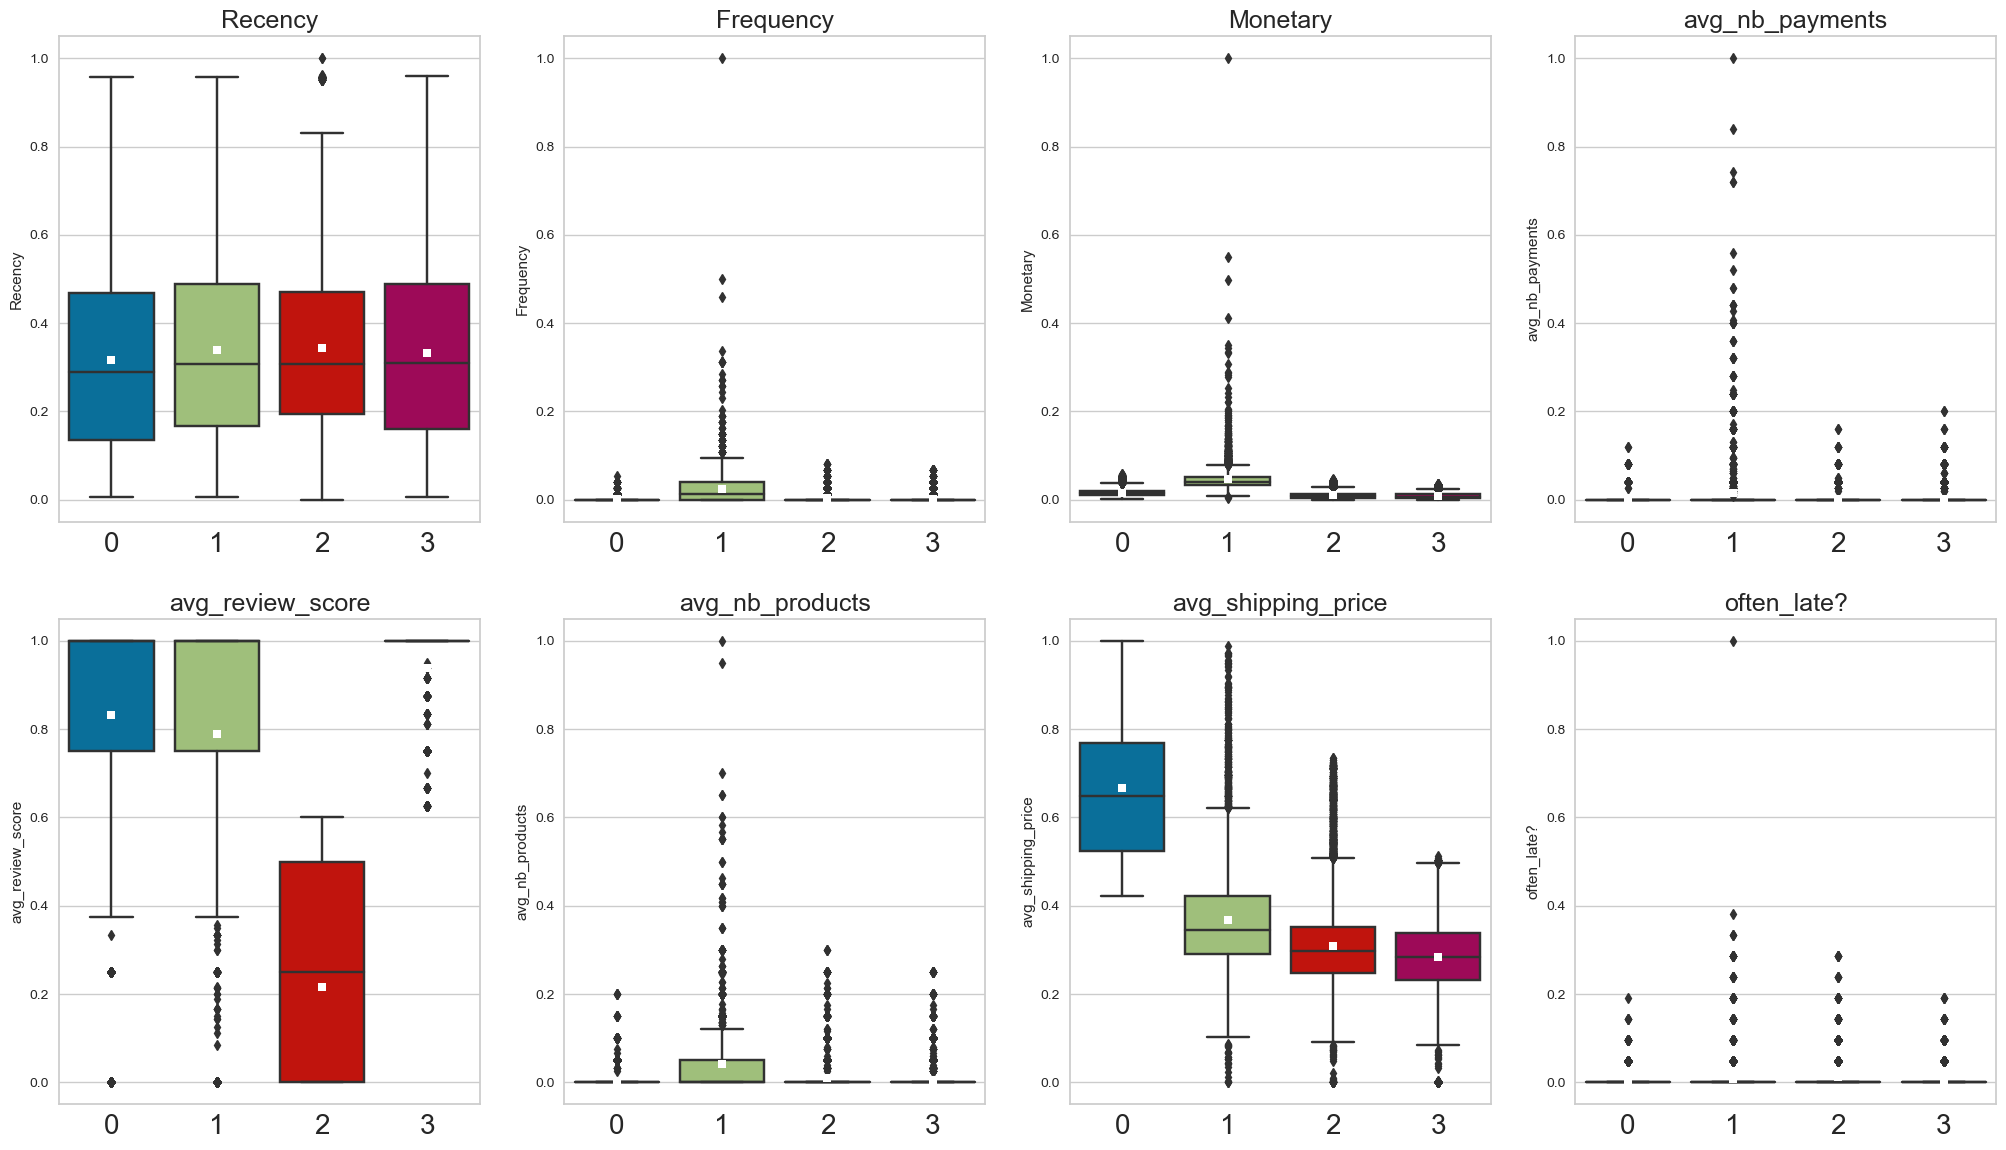

In [35]:
# Visualization
sns.color_palette("Set2")

cols = cls_num.columns

fig = plt.figure(figsize=(25,12))


for i in range(len(cols)-1):
    fig.subplots_adjust(top=1, wspace=.2)
    fig.add_subplot(2, 4, i+1)
    column = cols[i]
    ax = sns.boxplot(x = cls_num['KMeans_label'],
                     y = cls_num[column],
                     data=cls_grouped,
                     saturation=0.9,
                     showmeans=True,
                     meanprops={"marker":"s","markerfacecolor":"white"},

                    )
    ax.set(xlabel=None)
    ax.set_title("{}".format(column), fontsize=18)
    for tick in ax.get_xticklabels():
        tick.set_size(20)
    for tick in ax.get_yticklabels():
        tick.set_size(10)
    start = start + 1

sns.boxplot
    
plt.show()

From the boxplots, we see in a glimpse that what really creates variability is __review score__ and __shipping prices__, while the other variables are less distant from one another.

### Customers summary per feature

In [36]:
cls_summary = cls_df.describe(percentiles=[.25, .5, .75, .9, .95, .99])
idx = [1, 2, 3, 5, 7, 8, 9, 10]
cls_summary = cls_summary.iloc[idx]
cls_summary = cls_summary.rename({'90%' : 'Top 10%',
                                  '95%' : 'Top 5%',
                                  '99%' : 'Top 1%',
                                  }, axis='index')

cls_summary

,Recency,Frequency,Monetary,avg_nb_payments,avg_review_score,avg_nb_products,avg_shipping_price,often_late?,KMeans_label
mean,242.66,1.24,118.63,1.02,4.11,1.07,17.80,0.09,2.38
std,153.00,0.85,130.17,0.18,1.32,0.27,8.19,0.36,0.99
min,0.00,1.00,0.85,1.00,1.00,1.00,0.00,0.00,0.00
50%,223.00,1.00,85.00,1.00,5.00,1.00,16.11,0.00,3.00
Top 10%,471.00,2.00,244.90,1.00,5.00,1.33,27.44,0.00,3.00
Top 5%,524.00,2.00,339.00,1.00,5.00,1.50,36.15,1.00,3.00
Top 1%,580.00,4.00,550.00,1.50,5.00,2.20,47.85,1.00,3.00
max,728.00,75.00,"9,888.00",13.50,5.00,11.00,53.46,21.00,3.00


### Clusters summary per feature

In [37]:
# Showing the Groups table again
cls_grouped['Group size'] = groups_size
cls_grouped

,Recency,Frequency,Monetary,avg_nb_payments,avg_review_score,avg_nb_products,avg_shipping_price,often_late?,Group size
KMeans_label,,,,,,,,,
0,230.20,1.10,160.61,1.01,4.33,1.03,35.62,0.07,9450
1,246.89,2.72,463.58,1.19,4.16,1.41,19.60,0.15,4845
2,249.48,1.26,100.80,1.01,1.86,1.10,16.46,0.27,17312
3,242.30,1.14,87.81,1.01,4.75,1.04,15.11,0.04,57081


### Clusters interpretation

__Group A :__
(Customers number = 4845)

This group is the smallest but arguably the "Top clients" group. Eventhough they aren't the most recent customers (last purchase = *246 days* vs *avg = 242*), they do buy product more often than any others (in the Top 5% of all customers), which means that they are also older and therefore more loyal. Moreover, they are part of the Top 5% in spending, making them the most monetary-valuable group. Finally, they are also those who order the highest number of products per order.

> Advice: Target them with a *Come back* type of offer, because __Recency__ is their only caveat. 




__Group B :__
(Customers number = 57081)

This is the biggest group, by far. They are the most satisfied customers, quite highly above average (*4.75 vs avg=4.11*) which reinforces the idea that median reviewers do not really exist (as seen in the exploration notebook). We can also note that they have the lowest delay proportion (only 4% of order arrived with a delivery delay). Maybe those two observations are related.

 > Advice: On the other hand, this group has the __lowest monetary value of all__ (*87.81R$* vs *avg=119* per customer!). We should focus on improving their average basket value, maybe with additionnal product recommendations.

__Group C :__
(Customers number = 17312)

Eventhough they bought several times (1.26 orders per customer on average, which makes them the second group), and each time several products (they are also second in terms of article per order), they are __very unsatisfied__: Review_score = *1.86* against a mean of *4.11* and they are also the least recent customers (*250 days* on average).

 > Advice: 27% of their order arrived late (vs 9% on average)... Work on logistics and tell them, so they may come back and become part of the best customers.

__Group D :__
(Customers number = 9450)

They are the less frequent buyers, and have the highest average shipping price (among the Top 5% most expensive ones). If we consider that the shipping price depends on the quantity of products ordered, this might explain why they have the smallest number of products per order. Also, they might represent the "big/heavy" products buyers, which could also explain high shipping prices. It could therefore be interesting to analyse the type of product they buy most, also because with a monetary value of 160, they have an interesting money/article ratio.

 > Advice: Try to lower shipping prices, but because this group is only about 10% of the total customers, I wouldn't focus on them first.

In [38]:
# CSV exports
cls_df.to_csv('Data/cls_df.csv', index = False)
cls_recoded.to_csv('Data/cls_recoded.csv', index = False)

### DBSCAN

After having proper results with the Kmeans, I want to compare with a DBSCAN clustering algorithm (which is an advanced kind of KNN) to assess the potential differences in terms of results. 

In [39]:
from sklearn.cluster import DBSCAN

As for the KMeans, we are going to omit the two categorical variables from the fit.

In [40]:
# Data selection
dbscan_data = cls_df[numerical_features]

We start by looking the mean distance between two points for our entire dataset, so that 90% of the points have a distance to their nearest-neighborg inferior to epsilon.

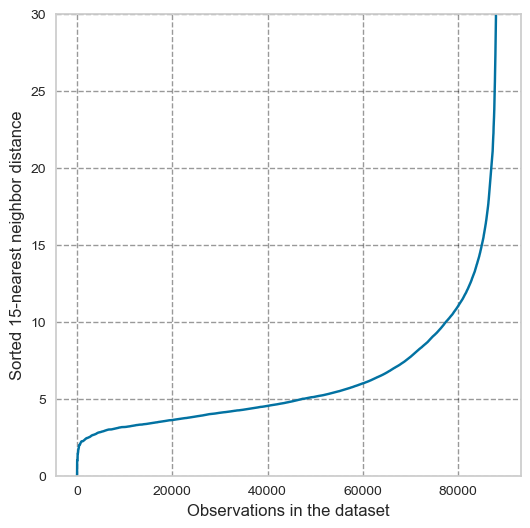

In [43]:
# First hyperparameter research: epsilon
from sklearn.neighbors import NearestNeighbors
def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(6,6))
    plt.plot(distances)
    plt.xlabel('Observations in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.ylim([0, 30])
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()


k = 2 * dbscan_data.shape[-1] - 1 # k=2*{dim(dataset)} - 1
get_kdist_plot(X=dbscan_data, k=k)

It seems that the correct distance to take is 15.
Also, the usually-accepted value of minimum neighbors to take is twice the number of features. As we have 8 of them, we'll take 16 min neighbors.

In [45]:
## DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
start = time.time()

db = DBSCAN(eps = 15, min_samples = 16).fit(dbscan_data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(dbscan_data, labels))
stop = time.time()
training_time = stop-start

Estimated number of clusters: 18
Estimated number of noise points: 2054
Silhouette Coefficient: 0.261


In [46]:
print("Training time: %d" % training_time)

Training time: 117


The algorithm find 18 clusters, and 2054/94000 points seem to be noise. 

This quite high number of clusters would certainly make the interpretation of the results quite messy.
Moreover, with a silhouette score of 0.261, the DBSCAN has a lower performance than the Kmeans (silhouette = 0.291).

Therefore, we are going to stick with the Kmeans++ model.